## CLASSIFICATION OF USER SATISFACTION LEVELS USING AMAZON DATA 


### 1. INTRODUCTION

It is very interesting to study all the comments relating to a product on the internet. This can have several practical applications. In particular, if we are able to determine the feelings of consumers on certain products, we can offer better services, more targeted advertisements or provide better analyzes of the evolution of the market. To investigate this, we found an Amazon database from Kaggle. This database contains several million reviews as well as a label based on the number of stars awarded. We will therefore try to find the best way to classify comments to convey the feeling of a user.

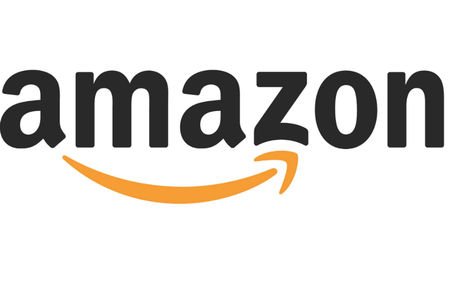

To perform this project, we will first load the data from the Kaggle site and prepare it. We will mainly study two different ways of classifying comments: the naie  baysian machine learning approach and the sentiment anaysis.

In [1]:
# import libraries

import numpy as np
import pandas as pd 

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import  seaborn  as  sns 
import  matplotlib.pyplot  as  plt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn import svm
from sklearn.svm  import  SVC

from  afinn  import  Afinn

### 2. The data

#### 2.1 Data cleaning process

Firstly, we import the text file as a form of pandas datafrme with a review column and a score column.The label has the value of either 1 or 2. 1 if the user has given 1 or 2 stars. 2 if it gave 4 or 5 stars. Neutral comments (3 stars) are not labeled in the database.

In [2]:
# import train dataset (txt file) as a pandas data frame and check the structure

df = pd.read_fwf('test.ft.txt', header = None)
df.head()

,0,1
0,__label__2,Great CD: My lovely Pat has one of the GREAT v...
1,__label__2,One of the best game music soundtracks - for a...
2,__label__1,Batteries died within a year ...: I bought thi...
3,__label__2,"works fine, but Maha Energy is better: Check o..."
4,__label__2,Great for the non-audiophile: Reviewed quite a...


In [3]:
# check the number of observations and columns

df.shape

(400000, 2)

In [4]:
# name the columns and see first few rows

df.columns = ['label','review']
df.head()

,label,review
0,__label__2,Great CD: My lovely Pat has one of the GREAT v...
1,__label__2,One of the best game music soundtracks - for a...
2,__label__1,Batteries died within a year ...: I bought thi...
3,__label__2,"works fine, but Maha Energy is better: Check o..."
4,__label__2,Great for the non-audiophile: Reviewed quite a...


Due to the enourmous size of files, we will take random samples from the whole dataset. Then we will make a new column name 'rate'. The 'label 1' would get the value 'negative', and 'label 2' will have 'positive'. Then we will take a look how many observations we have for the both categories

In [5]:
# ramdomly choose 10000 samples out of the whole dataset

df = df.sample(10000, random_state = 42)
df.describe()

,label,review
count,10000,10000
unique,2,10000
top,__label__2,Rather disappointing - Seagates own manuals ar...
freq,5028,1


In [6]:
# rename the columns and drop the label column

df['rate'] = np.where(df['label'] == '__label__1', 'negative', 'positive')
df = df.drop('label',axis=1)
df.head()

,review,rate
23218,This is a great book: I must preface this by s...,positive
20731,"Huge Disappointment.: As a big time, long term...",negative
39555,Wayne is tight but cant hang with Turk.: This ...,positive
147506,Excellent: I read this book when I was in elem...,positive
314215,Not about Anusara: Although this book is toute...,negative


In [7]:
# select only positive/ negative reviews

df_pos = df[df['rate'] == 'positive']
df_neg = df[df['rate'] == 'negative']

In [8]:
# check the number of positive reviews

df_pos.describe()

,review,rate
count,5028,5028
unique,5028,1
top,Wireless Rf Mini Multimedia USB Kyb with optic...,positive
freq,1,5028


In [9]:
# check the number of negative reviews

df_neg.describe()

,review,rate
count,4972,4972
unique,4972,1
top,Rather disappointing - Seagates own manuals ar...,negative
freq,1,4972


We obtained the similar number of observations for both from the sample.

Now we will process the sentencess. Firstly We will remove stopword such as symbols. In addition, change every words in lower cases. We also remove some words that are commonly shown frequently in both positive and negative reviews.

In [10]:
import string

# define stopwords to be removed from the library

stop = stopwords.words('english')

# add more stopwords after checking the most frequently used word on the dataset

stop = stop + ['book', 'one', 'music', 'film', 'movie', 'song', 'even', 'use', 'read', 'good', 'really', 'like', 'would' ]

# define a function for text processing

def txtprocess(messages):
    
    nopunc = [char for char in messages if char not in string.punctuation] 
    
    nopunc = ''.join(nopunc)

    return ' '.join([word.lower() for word in nopunc.split() if word.lower() not in stop])

In [11]:
# make a new column with processed sentences

df['processed'] = df['review'].apply(txtprocess)
df.head()

,review,rate,processed
23218,This is a great book: I must preface this by s...,positive,great must preface saying religious loved enjo...
20731,"Huge Disappointment.: As a big time, long term...",negative,huge disappointment big time long term trevani...
39555,Wayne is tight but cant hang with Turk.: This ...,positive,wayne tight cant hang turk album hot wants how...
147506,Excellent: I read this book when I was in elem...,positive,excellent elementary school probably fourth gr...
314215,Not about Anusara: Although this book is toute...,negative,anusara although touted several anusara web si...


#### 2.2 Descriptive statistics

In this section, we will take a look which word are shown in the reivews, separating them into positive and negative categories. 

In [13]:
# making two dataframes based on the ratings

df_pos = df[df['rate'] == 'positive']
df_neg = df[df['rate'] == 'negative']

In [14]:
# make lists of words from the processed texts

word_pos = ''.join(df_pos['processed'])
word_neg = ''.join(df_neg['processed'])

# tokenize the sentence

tokenized_word_pos = word_tokenize(word_pos)
tokenized_word_neg = word_tokenize(word_neg)

In [15]:
# ploting the count

fdist_pos = FreqDist(tokenized_word_pos)
fdist_neg = FreqDist(tokenized_word_neg)

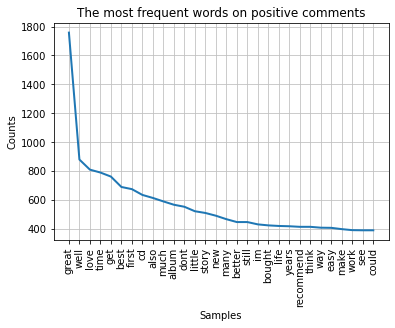

In [16]:
# a graph of the words from positive reviews

fdist_pos.plot (30 , cumulative = False ,  title  = 'The most frequent words on positive comments') 
plt.show()

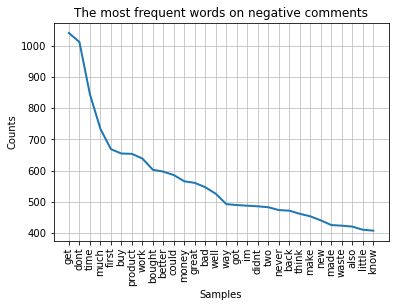

In [17]:
# a graph of the words from negative reviews

fdist_neg.plot (30 , cumulative = False ,  title  = 'The most frequent words on negative comments') 
plt.show()

Through this process, we found out that there several words used frequently for both cases. These were the product that amazon is selling such as 'book', 'movie', and 'music'. Therefore we also remove this words while we process our texts.

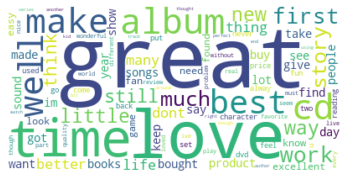

In [18]:
# word cloud for positive comments

text = ''.join(df_pos['processed'])
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white", colormap = 'viridis').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

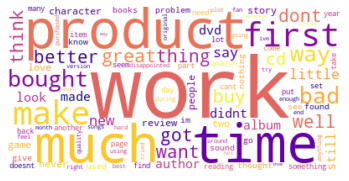

In [18]:
## word cloud for negative comments

text = ''.join(df_neg['processed'])
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white", colormap='plasma').generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Despite of the text processing, we still have words common to both categories. We can therefore suspect that this will burden our following performance. For example, the presence of the words 'great' or 'well' in negative comments will inevitably cause problems.

### 3. Sentiment analysis

We will use afinn library for this analysis. The main function of the library is giving sentiment scores of the sentence based on the lexicon. We will measure the sentiment scores of reviews and the compare the results with the actual ratings. The score below 0 is classified negative, and vice versa. The sentences with 0 score will be categorized as 'neutral' sentiment.

In [19]:
# apply afinn to processed reviews

afinn = Afinn() 

# make a new column 'scores'
df['scores'] = [afinn.score(sent) for sent in df['processed']]

# make a new column 'sentiment' based on the scores.

df['sentiment'] = ['positive'  if score > 0 
                      else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in df['scores']]

In [20]:
# description of the each categories

df.groupby(by=['rate']).describe()

scores                                                
           count      mean       std   min  25%  50%   75%   max
rate                                                            
negative  4972.0 -0.167940  6.199181 -36.0 -4.0  0.0   3.0  36.0
positive  5028.0  7.758552  6.885301 -20.0  3.0  7.0  12.0  50.0

The result indicates that review with positive ratings have higher sentiment scores, with mean of 7.7. However, the other category have - 0.16, which is very close to 'neutral' sentiment.

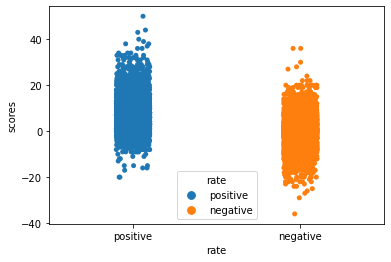

In [21]:
sns.stripplot(x = 'rate', y = 'scores', 
                   hue = 'rate', data=df)
plt.show()

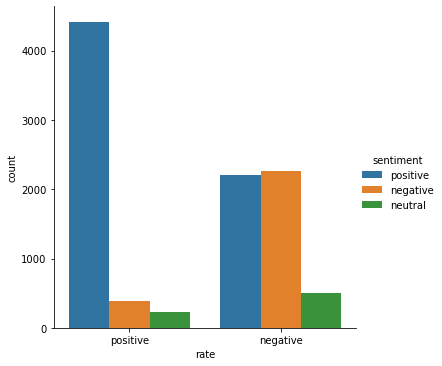

In [22]:
sns.catplot(x = 'rate', hue = 'sentiment', data=df, kind="count")

Here, we see the very poor sorting of negative comments.

This method can nevertheless be useful for identifying certain comments, such as the most "positive" or the most "negative".

The linguistic method gave therefore unsatisfactory outcome. It is also impractical to identify nuanced comments. On the other hand, it is practical for identifying extreme comments.

### 4. Naive baysian machine learning analysis

#### 4.1 NB modeling

To begin with, we assume that the features are independent of each other. Then we do a naive Bayesian supervised classification

We therefore use the train_data database whose features we will vectorize. We take 3000 features in order to be able to run the algorithm quickly.

In [23]:
cv = TfidfVectorizer(max_features= 3000) 

X = cv.fit_transform(df["processed"])
Y = df['rate']

In [24]:
# split sets into train/test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

Then we apply the NB algorithm. Given the data, we will consider a multinomial law.

In [25]:
classifier = MultinomialNB().fit(x_train, y_train)

#### 4.2 Performance tests 

We will examine the confusion matrix, the accuracy, as well as f1-score.

In [26]:
pred = classifier.predict(x_test)
cm = confusion_matrix(y_test, pred)
acc = accuracy_score(y_test, pred)
print(classification_report(y_test, pred))
print()
print('Confusion Matrix:\n',cm)
print()
print('Accuracy : ', acc)

              precision    recall  f1-score   support

    negative       0.82      0.84      0.83      1213
    positive       0.84      0.83      0.84      1287

    accuracy                           0.83      2500
   macro avg       0.83      0.83      0.83      2500
weighted avg       0.83      0.83      0.83      2500


Confusion Matrix:
 [[1015  198]
 [ 221 1066]]

Accuracy :  0.8324


We obtain an accuracy of 0.831 which is generally satisfactory.

#### Sources

https://www.kaggle.com/datasets/bittlingmayer/amazonreviews

https://github.com/fnielsen/afinn